<a href="https://colab.research.google.com/github/KimaniKibuthu/US-Airline-Tweet-Sentiment-Analysis/blob/main/Tweets_of_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# US Airline Tweet Analysis

## Introduction

Perform Sentiment analysis using BERT on Twitter US Airline Sentiment and apply the EDA augmentation

## Methodology
The methodology will be as follow:
1. Data Obtainance, Preparation and Exploration.
2. Modelling.
3. Testing.



# Libraries & Functions


## Libraries

In [ ]:
# Install tensorflow text
!pip install tensorflow_text


In [ ]:
# Install ktrain wrapper for bert model training
!pip install ktrain

In [ ]:
# Install the nlpaug library for text augmentation
!pip install nlpaug


In [ ]:
# Import necessary libraries
import re
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


import tensorflow as tf
import tensorflow_text

from wordcloud import WordCloud, STOPWORDS
import ktrain
from ktrain import text
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import nlpaug.augmenter.word as naw

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Functions

In [ ]:
# Tests models
def model_tester(path, x, y):
    """
  Validates model using test data

  Args:
      path (str): Path of saved model
      x (tuple): feature data tuple
      y (tople): target data tuple

  Prints:
  The accuracy and f1 score
  """

    # Get the saved model
    model = ktrain.load_predictor(path).model

    # Load the data
    x_train, x_test = x
    y_train, y_test = y

    # Ready the data
    (_, _), (x_test_bert, y_test_bert), _ = text.texts_from_array(x_train=x_train, 
                                                                  y_train=y_train,
                                                                  x_test=x_test,
                                                                  y_test=y_test,
                                                                  preprocess_mode='bert',
                                                                  maxlen=21,
                                                                  max_features=2500)

    # Get the accuracy
    metrics = model.evaluate(x_test_bert, y_test_bert)
    accuracy = metrics[1]

    # Get the f1 score
    predictions = np.argmax(model.predict(x_test_bert), axis=1)
    y_true = np.argmax(y_test_bert, axis=1)

    f1_scores = f1_score(y_true, predictions, average=None)

    print(
        f'The Accuracy is {accuracy}, the F1 score for the negatives is {f1_scores[0]},'
        f' and the F1 score for the positives is {f1_scores[1]}')


# Function that prints random words
def word_printer(texts):
    """
  Function that prints a sample of texts

  Args:
    texts (list): A list containing texts

  Prints:
    A sample of 15 texts
  """
    i = 0
    while i < 15:
        print(random.choice(texts))
        i += 1


# Text Cleaner 
def bert_preprocess_text(texts):
    """
  Clean texts and readies them for bert preprocessing

  Args:
    texts (list): A list containing texts to be cleaned
  
  Returns:
    new_texts (list):A list containing cleaned text

  """
    new_texts = []
    for word in texts:
        # Make lower
        word = word.lower()

        # Remove url
        word = re.sub(r'https?:\/\/\S+', '', word)
        word = re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', word)

        # Remove punctuation
        word = re.sub(r'[^\w\s]', '', word)

        # Remove placeholders
        word = re.sub(r"\[video\]", '', word)
        word = re.sub(r'{link}', '', word)

        # HTML and non letter characters
        word = re.sub(r'&[a-z]+;', '', word)
        word = re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', word)

        # Remove mentions
        word = re.sub('@[\w]+', '', word)

        # Remove airline names
        word = re.sub('virginamerica', '', word)
        word = re.sub('united', '', word)
        word = re.sub('americanair', '', word)
        word = re.sub('usairways', '', word)
        word = re.sub('deltaassist', '', word)
        word = re.sub('southwestair', '', word)
        word = re.sub('jetblue', '', word)

        # lemmatize and remove stop words
        tokens = word_tokenize(word)
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
        word = ' '.join(tokens)

        # Append clean texts to new_texts
        new_texts.append(word)

    # Tokenize texts

    return new_texts


# Bert model trainer
def bert_trainer(x, y, bert_model, file_name):
    """
  Trains, validates and saves BERT model. Done using the ktrain wrapper.

  Args:
    x (tuple): Set containing train and test feature sets
    y (tuple): Set containing train and test target sets
    bert_model (str): Name of bert model
    file_name (str): Path to save model 

  """
    # Set seed
    tf.random.set_seed(123)

    # split the data
    x_train, x_test = x
    y_train, y_test = y

    # Make data ready for bert model
    (x_train_bert, y_train_bert), (x_val_bert, y_val_bert), preprocessor = text.texts_from_array(
        x_train=x_train, y_train=y_train,
        x_test=x_test, y_test=y_test,
        preprocess_mode=bert_model,
        maxlen=21,
        max_features=2500)

    # Create model
    model = text.text_classifier(bert_model,
                                 train_data=(x_train_bert, y_train_bert),
                                 preproc=preprocessor,
                                 metrics=['accuracy'])
    # Create learner
    learner = ktrain.get_learner(model,
                                 train_data=(x_train_bert, y_train_bert),
                                 val_data=(x_val_bert, y_val_bert))
    # Fit learner
    learner.autofit(1e-4)

    # Validate learner
    learner.validate((x_val_bert, y_val_bert),
                     class_names=['negative', 'positive'])

    # Save model
    ktrain.get_predictor(model, preprocessor).save(file_name)


# Word cloud generator
def word_cloud_generator(df, category):
    """
    Generating Word Cloud

    Args:
       df (DataFrame): tweets dataset
       category (str): category you want populated

    Prints:
        A word cloud

    """
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.airline_sentiment == category]['text']])

    # Initialize word cloud object
    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords=STOPWORDS)
    # Visualize
    plt.figure(figsize=(10, 10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()


# Slitter of data
def data_splitter(x, y, train_size):
    """
  Splits data

  Args:
    x (array, DataFrame): features
    y (array, DataFrame): target
    train_size (float): amount by which to split data

  Returns:
    x_train (array): train tuple features
    x_preliminary (array): test tuple features
    y_train (array): train tuple target
    y_preliminary (array): test tuple target
    
  """
    # Split data
    x_train, x_preliminary, y_train, y_preliminary = train_test_split(x,
                                                                      y,
                                                                      train_size=train_size,
                                                                      random_state=7,
                                                                      stratify=y)

    return x_train, x_preliminary, y_train, y_preliminary


# Text augmenter
def text_augmenter(df, augmenter_type):
    """
  Augments text and return dataframe containing original and augmented text 
  and a balanced dataset containing 54% negatives and 46% positives.

  Args:
     df (DataFrame): DataFrame containing data that you want to augment
     augmenter_type (str): The augmentation type (synonym, context or delete)

  Returns:
    new_df (DataFrame): DataFrame containing augmented data and original data
  """
    # Empty lists to contain augmented texts
    augmented_positives = []
    augmented_negatives = []

    # Get positive and negative texts from df
    positive_texts = list(df.loc[df['airline_sentiment'] == 'positive', 'text'].values)
    negative_texts = list(df.loc[df['airline_sentiment'] == 'negative', 'text'].values)

    # Loop through the text lists and augment
    for positive_text, negative_text in zip(positive_texts, negative_texts):
        aug = None
        if augmenter_type == 'context':
            aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased',
                                            action='insert',
                                            aug_p=0.1)

        elif augmenter_type == 'synonym':
            aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.1)

        elif augmenter_type == 'delete':
            aug = naw.RandomWordAug(action='delete', aug_p=0.1)

        positive_augmented_text = aug.augment(positive_text, n=4)
        negative_augmented_text = aug.augment(negative_text, n=2)

        # Append augmented texts to empty lists
        augmented_positives.extend(positive_augmented_text)
        augmented_negatives.extend(negative_augmented_text)

    # Create dataframe with augmented and positive values
    positive_texts.extend(augmented_positives)
    positives = pd.DataFrame({'text': positive_texts, 'airline_sentiment': 'positive'})
    # Create dataframe with augmented and positive values
    negative_texts.extend(augmented_negatives)
    negatives = pd.DataFrame({'text': negative_texts, 'airline_sentiment': 'negative'})

    # Join the two dataframes and shuffle the dataframe
    new_df = pd.concat([positives, negatives], ignore_index=True)
    new_df = new_df.sample(frac=1, ignore_index=True)

    return new_df


# augmented model trainer
def augmented_model_trainer(augmenter_type, train_data, val_data, filename):
    """
  Trains model on augmented data

  Args:
    augmenter_type (str): The augmentation type (synonym, context or delete)
    train_data (DataFrame): DataFrame containing data to be augmented
    val_data (tuple): Set containing x_val and y_val
    filename (str): Path to save model

  """
    # Augment data
    augmented_train_df = text_augmenter(train_data, augmenter_type)

    # Split data
    x_train_new = augmented_train_df['text'].to_numpy()
    y_train_new = augmented_train_df['airline_sentiment'].to_numpy()

    x_val, y_val = val_data

    # Train, validate and save model
    bert_trainer(x=(x_train_new, x_val),
                 y=(y_train_new, y_val),
                 bert_model='bert',
                 file_name=filename)


# Data Obtainance, Preparation and Exploration

## Data Obtainance


In [ ]:
# Load the data
tweets = pd.read_csv('data/Tweets.csv')

tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Data Exploration
Explore the data

In [ ]:
# Get info on the data
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

Let's explore the columns and analyse their importance.

**Airline Sentiment**

In [ ]:
# Investigate the value counts
tweets['airline_sentiment'].value_counts(normalize=True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

The data is clearly imbalanced. We can try three ways and compare the performance.

1. Down-sample the negative samples to equal the neutral values.
2. Upsample the neutral and positive using nlp aug.

The best way to handle this imbalance will be to **upsample** the **positives** using nlpaug before running the data through the BERT model.

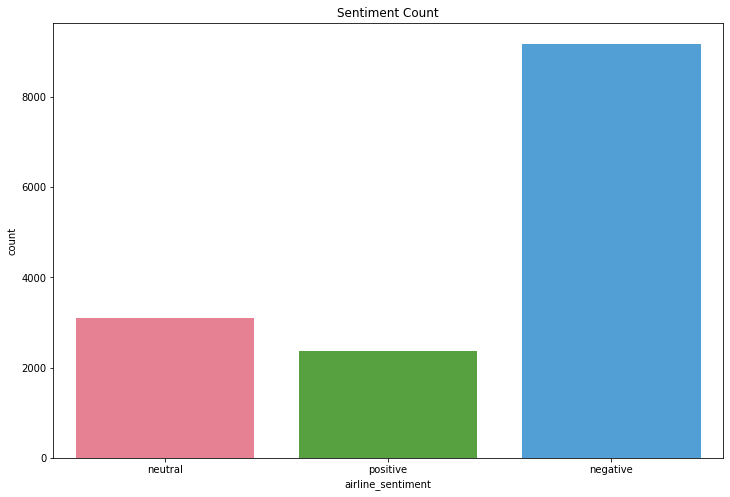

In [ ]:
# Visualize the value counts
plt.figure(figsize=(12,8))
sns.countplot(data=tweets,
              x='airline_sentiment',
              palette='husl').set(title='Sentiment Count');

**Airline sentiment confidence**

<Figure size 864x576 with 0 Axes>

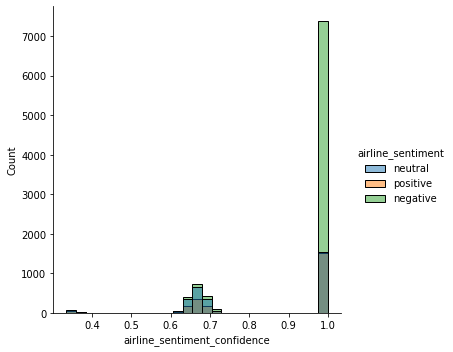

In [ ]:
# Check the distribution
plt.figure(figsize=(12,8))
sns.displot(data=tweets, x='airline_sentiment_confidence', hue='airline_sentiment')

It seems that more sentiments that had a score of 1 in the confidence were negative

**Negative reason**

What were the negative reasons given?

In [ ]:
# Check Unique values
labels = tweets['negativereason'].unique()

print(labels)

[nan 'Bad Flight' "Can't Tell" 'Late Flight' 'Customer Service Issue'
 'Flight Booking Problems' 'Lost Luggage' 'Flight Attendant Complaints'
 'Cancelled Flight' 'Damaged Luggage' 'longlines']


In [ ]:
# Substitute the null values with unstated

tweets['negativereason'].fillna('unstated', inplace=True)

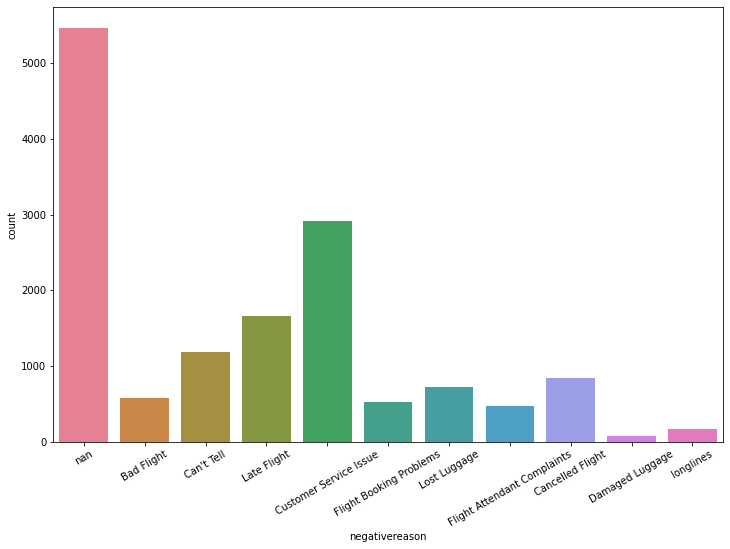

In [ ]:
# View
plt.figure(figsize=(12,8))
sns.countplot(data=tweets,
              x='negativereason',
              palette='husl').set_xticklabels(labels=labels,
                                              rotation=30);

Most negative reasons were unstated. However, The most that were stated were mostly sorrounding customer service. We can categorize them into: Unstated, Flight Issues, Customer Service Issue and Luggage issues

In [ ]:
# Categorize the reasons

# Unstated
tweets.loc[(tweets['negativereason']=='unstated') | (tweets['negativereason']=='Can\'t Tell'), 'negativereason'] = 'Unstated'

# Flight Issues
tweets.loc[(tweets['negativereason']=='Bad Flight') | (tweets['negativereason']=='Late Flight') | (tweets['negativereason']=='Cancelled Flight'), 'negativereason'] = 'Flight issues'

# Customer Service
tweets.loc[(tweets['negativereason']=='Customer Service Issue') | (tweets['negativereason']=='Flight Booking Problems')| (tweets['negativereason']=='Flight Attendant Complaints') | (tweets['negativereason']=='longlines'), 'negativereason'] = 'Service issues'

# Luggage issues
tweets.loc[(tweets['negativereason']=='Lost Luggage') | (tweets['negativereason']=='Damaged Luggage'), 'negativereason'] = 'Luggage Issue'


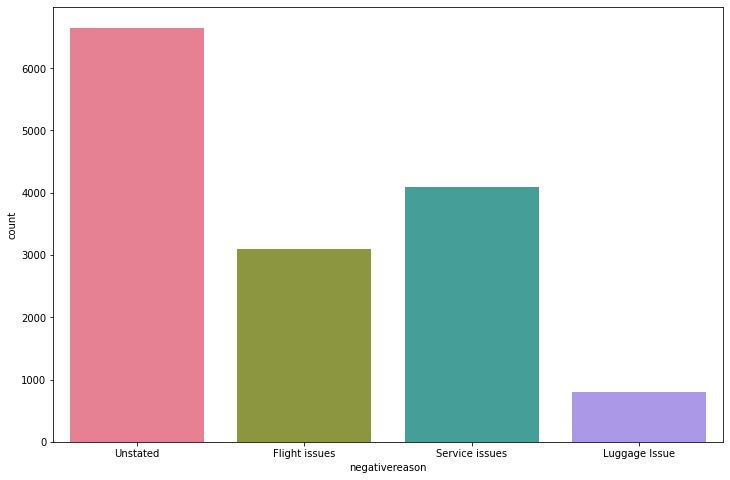

In [ ]:
# View
plt.figure(figsize=(12,8))
sns.countplot(data=tweets,
              x='negativereason',
              palette='husl');

It is clear that despite the unstated reasons, most negative reasons were due to service issues, followed by flight issues and luggage issues respectively.

**Airline**

Which airline has more negative reviews

In [ ]:
# Check Airlines
labels = tweets['airline'].unique()

print(labels)

['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']


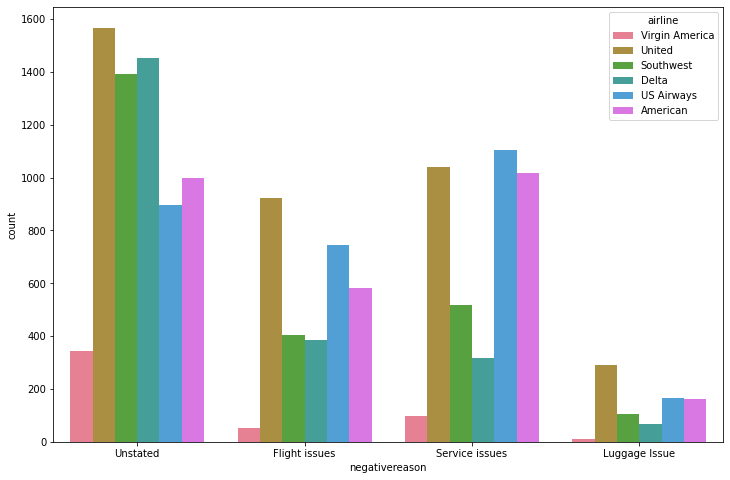

In [ ]:
# View
plt.figure(figsize=(12,8))
sns.countplot(data=tweets,
              x='negativereason',
              hue='airline',
              palette='husl')

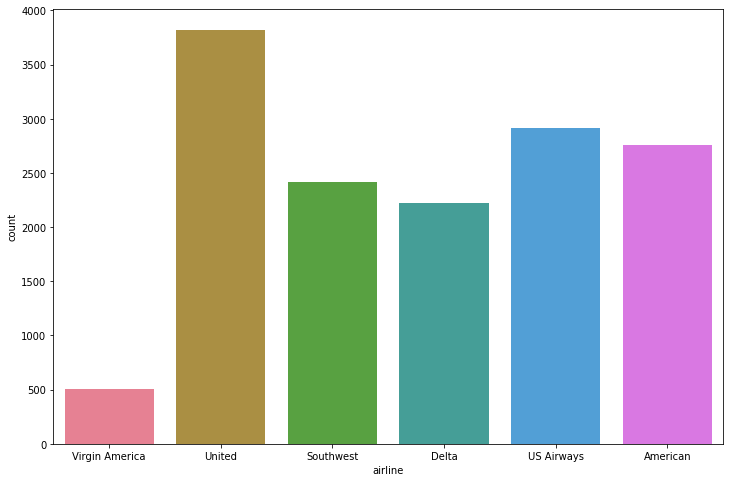

In [ ]:
# View
plt.figure(figsize=(12,8))
sns.countplot(data=tweets,
              x='airline',
              palette='husl')

In [ ]:
# Count of negative reason

airlines = tweets['airline'].unique()

for airline in airlines:
  print(airline)
  temp_df = tweets.loc[tweets['airline']==airline]
  print(temp_df['airline_sentiment'].value_counts(normalize=True))
  print('-'*30)




Virgin America
negative    0.359127
neutral     0.339286
positive    0.301587
Name: airline_sentiment, dtype: float64
------------------------------
United
negative    0.688906
neutral     0.182365
positive    0.128728
Name: airline_sentiment, dtype: float64
------------------------------
Southwest
negative    0.490083
neutral     0.274380
positive    0.235537
Name: airline_sentiment, dtype: float64
------------------------------
Delta
negative    0.429793
neutral     0.325383
positive    0.244824
Name: airline_sentiment, dtype: float64
------------------------------
US Airways
negative    0.776862
neutral     0.130793
positive    0.092345
Name: airline_sentiment, dtype: float64
------------------------------
American
negative    0.710402
neutral     0.167814
positive    0.121783
Name: airline_sentiment, dtype: float64
------------------------------


It seems most of the negative comments were targeted towards US airways, American and United.



## Text preparation

In [ ]:
# Create df
bert_df = tweets[['airline_sentiment']]

# Add clean texts
texts = tweets['text'].values
clean_texts = bert_preprocess_text(texts)

bert_df['text'] = clean_texts

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Get texts to explore further
positive_texts = bert_df.loc[bert_df['airline_sentiment']=='positive', 'text'].values
neutral_texts = bert_df.loc[bert_df['airline_sentiment']=='neutral', 'text'].values
negative_texts = bert_df.loc[bert_df['airline_sentiment']=='negative', 'text'].values


In [ ]:
# A sample of cleaned positive texts
word_printer(positive_texts)

companion pas everyone deserves redcarpet treatment even mom
thankyou dalaus route make day
thanks got couple minute ago great service flight btw please pas team flight
love hipster innovation feel good brand
got phone customer service minute get issue resoled guy awesome
lmfao love
ahah love sw
thx ops agt rich westagard n flight att nancy den airportheld flight n even saved seat bus select customersfirst
lovely rt fleet fleek
kudos ticket agent making passenger check bag big fit overhead
thankful great service newark seat fixed seated daughter fab landing fort myers
following thank
knew reason u favorite airline read answer twitter globe morning great job
thank wonderful global first class flight fra great service cont
guy made day treated well thank


In [ ]:
# A sample of cleaned negative texts
word_printer(negative_texts)

trying add tsa pre check number reservation online dont see option nosecuritylines
im grounded montreal ua missing connection ua st louis helpdo private jet
san diego hour delay jfkeven amex even travel mile youre still nothing
dfpietra thats response shaking head back forth tsk betterfrom customer service apology
hour late flightr lost conection
hr searching flts find site amp cant book offered bc seg isnt really available lie falseadvertising
compensates delay caused fact dont enough flight attendant
instead told board wait email telling u delay
youre honoring mile traveled last year
link lead website wont open cell phone good job shocking airline folding
whats new inflight wifi service super crappy user experience miss old provider
ahhhh silence golden top anyone get fired
please help youve rebooked incorrectly flight cancelled flightled please fix flt tuesday
havent rebooked called left number callback havent heard anything flight tomorrow
understand flight day going twice im extra

In [ ]:
# A sample of cleaned neutral texts
word_printer(neutral_texts)

id like spread grandpa ash naples italy lived serving yr usnavy flyitforward
get stand list ase ord im poor person aspen thats im asking standby twitter
issue finding missing item plane help find airport plane headed next
winner destinationdragons announced
service aruba permanently discontinued august
pty pit via iah
flight columbus ohio dallas texas cancelled flighted
new ceo seek right balance please passenger wall daily journal
even offered fly another airport said couldnt explanation cant
oh saw said nothing
originating sfo going lax
played bizarre safety video ive ever seen
flight number different flight im heading mpls
left personal stuff u phlbos hour ago went baggage told plane left call
still use dc


Drop the neutrals and keep the positive and the negative texts which are more important.

In [ ]:
# Drop neutral 
bert_df_new = bert_df.loc[(bert_df['airline_sentiment']=='positive') | (bert_df['airline_sentiment']=='negative') ]

**Explore Positive & Negative word clouds**

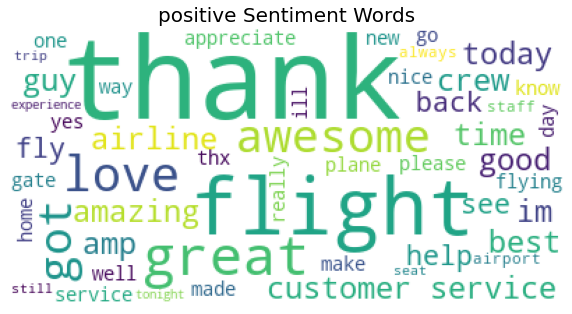

In [ ]:
# Positive
word_cloud_generator(bert_df_new, 'positive')

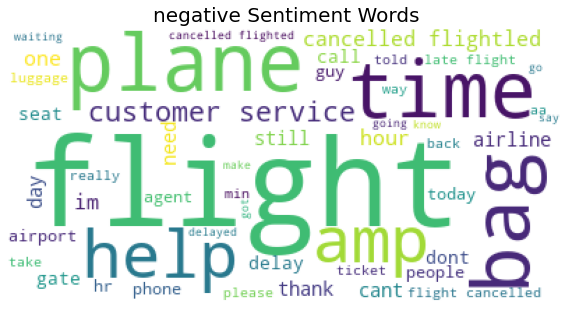

In [ ]:
# Negative
word_cloud_generator(bert_df_new, 'negative')

**Split the data**

In [ ]:
# Split data
x = bert_df_new['text'].to_numpy()
y = bert_df_new['airline_sentiment'].to_numpy()


x_train, x_prel, y_train, y_prel = data_splitter(x,y, train_size=0.7)
x_test, x_val, y_test, y_val = data_splitter(x_prel, y_prel, train_size=0.5)

# Modelling Using BERT

## No augmentation

In [ ]:
# Train model with unaugmented data
bert_trainer(x=(x_train, x_val),
             y=(y_train, y_val),
             bert_model = 'bert',
             file_name='/content/unaugmented_model')

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
Is Multi-Label? False
maxlen is 21
done.
early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
253/253 [==============================] - 116s 358ms/step - loss: 0.2515 - accuracy: 0.8995 - val_loss: 0.1925 - val_accuracy: 0.9284
Epoch 2/1024
253/253 [==============================] - 85s 338ms/step - loss: 0.1389 - accuracy: 0.9478 - val_loss: 0.2030 - val_accuracy: 0.9249
Epoch 3/1024
253/253 [==============================] - 85s 337ms/step - loss: 0.0875 - accuracy: 0.9688 - val_loss: 0.2143 - val_accuracy: 0.9203

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
Epoch 4/1024
253/253 [==============================] - 85s 338ms/step - loss: 0.0368 - accuracy: 0.9891 - val_loss: 0.3163 - val_accuracy: 0.9192
Epoch 5/1024
253/253 [==============================] - 85s 338ms/s

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Using Augmentation

Augment the data using the nlpaug. The strategies used will be:
1. Random insertion using contextual augmentation.
2. Synonym replacement.
3. Random deletion.

The augmentation will help assist in catering for the imbalance in the data.

The parameters of augmentation (As stated in the [paper](https://arxiv.org/pdf/1901.11196.pdf)) will include an aug_p of **0.1** for all the augmentors and the number of positive sentences generated be **4**.

In [ ]:
# Create train dataset
train_df = pd.DataFrame({'text':x_train, 'airline_sentiment': y_train})


In [ ]:
# Contextual model (Random Insertion)
augmented_model_trainer('context',
                        train_df, 
                        (x_val, y_val),
                        '/content/contextual_augmentation')

In [ ]:
# Synonym model (Synonym Replacement)
augmented_model_trainer('synonym',
                        train_df,
                        (x_val, y_val),
                        '/content/synonym_augmentation')

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
Is Multi-Label? False
maxlen is 21
done.
early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
563/563 [==============================] - 216s 336ms/step - loss: 0.2285 - accuracy: 0.9076 - val_loss: 0.0974 - val_accuracy: 0.9659
Epoch 2/1024
563/563 [==============================] - 184s 326ms/step - loss: 0.0655 - accuracy: 0.9785 - val_loss: 0.0899 - val_accuracy: 0.9781
Epoch 3/1024
563/563 [==============================] - 183s 326ms/step - loss: 0.0368 - accuracy: 0.9873 - val_loss: 0.1038 - val_accuracy: 0.9700
Epoch 4/1024
563/563 [==============================] - 184s 327ms/step - loss: 0.0307 - accuracy: 0.9902 - val_loss: 0.1007 - val_accuracy: 0.9752

Epoch 00004: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
Epoch 5/1024
563/563 [==============================] - 184s 327

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Random Deletion model
augmented_model_trainer('delete',
                        train_df,
                        (x_val, y_val),
                        '/content/random_deletion')

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
Is Multi-Label? False
maxlen is 21
done.
early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
563/563 [==============================] - 217s 336ms/step - loss: 0.2463 - accuracy: 0.9018 - val_loss: 0.1059 - val_accuracy: 0.9654
Epoch 2/1024
563/563 [==============================] - 184s 327ms/step - loss: 0.0820 - accuracy: 0.9712 - val_loss: 0.0911 - val_accuracy: 0.9711
Epoch 3/1024
563/563 [==============================] - 184s 327ms/step - loss: 0.0502 - accuracy: 0.9840 - val_loss: 0.1077 - val_accuracy: 0.9711
Epoch 4/1024
563/563 [==============================] - 184s 327ms/step - loss: 0.0316 - accuracy: 0.9901 - val_loss: 0.0885 - val_accuracy: 0.9723
Epoch 5/1024
563/563 [==============================] - 184s 327ms/step - loss: 0.0316 - accuracy: 0.9894 - val_loss: 0.1267 - val_accuracy: 0.9723
Epoch 6/

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


From the experiments, the **Synonym replacement** method of augmentation works best.

## Test models

In [ ]:
# Test on model trained with unaugmented data
model_tester('/content/unaugmented_model',
             x = (x_train, x_test),
             y = (y_train, y_test))

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
55/55 [==============================] - 11s 101ms/step - loss: 0.1790 - accuracy: 0.9261
The Accuracy is 0.9260542988777161, the F1 score for the negatives is 0.953956834532374, and the F1 score for the positives is 0.8123167155425219


In [ ]:
# Test on model trained with augmented data using synonym replacement
model_tester('/content/synonym_augmentation',
             x = (x_train, x_test),
             y = (y_train, y_test))

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
55/55 [==============================] - 11s 101ms/step - loss: 0.0817 - accuracy: 0.9763
The Accuracy is 0.9763142466545105, the F1 score for the negatives is 0.9851395433127944, and the F1 score for the positives is 0.9416785206258891


# Conclusion

From the results, the model trained using the **synonym augmentation method** realizes a **5%** increase in accuracy, a **2%** increase in f1_score of the negatives and a **13%** increase in the f1 score of the positives. 

It is clear then that augmentation helps ,to some extent, in improving a models performance when it comes to text classification.